# Sprint9
## ニューラルネットワークスクラッチ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

**データ読み込み**

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

**前処理**

In [3]:
#reshape
X_train=X_train.reshape(-1,784)
X_test=X_test.reshape(-1,784)

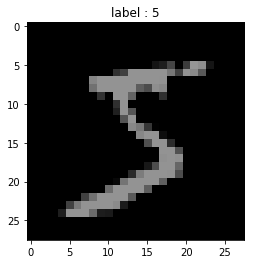

In [4]:
#データ可視化
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image,'gray',vmin=0, vmax=255)
plt.title('label : {}'.format(y_train[index]))
plt.show()
#print(image) # 値を確認

In [5]:
#グレースケールの標準化
X_train=X_train.astype(np.float)
X_test=X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [6]:
#データ分割
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2)

In [7]:
#ニューラルネットワークで多クラス分類を行う際には one-hot表現 に変換
enc=OneHotEncoder(handle_unknown='ignore',sparse=False)
y_train_one_hot=enc.fit_transform(y_train[:,np.newaxis])
y_test_one_hot=enc.transform(y_test[:,np.newaxis])

## ニューラルネットワークスクラッチ

## ミニバッチ処理

In [8]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    

In [32]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------
    alpha : flort
      学習率
    sigma : flort
      標準偏差
    epochs : int
      エポック数
    verbose : bool
      学習過程を出力する場合はTrue
    seed : int
      シードの指定値
      
    Attributes
    ----------
    """

    def __init__(self,alpha=0.01,sigma=0.01,epochs=50,verbose=True,seed=9):
        self.verbose = verbose
        n_features = X.shape[1] # 特徴量の数
        n_nodes1 = 400 # 1層目のノード数
        n_nodes2 = 200 # 2層目のノード数
        n_output = y.shape[1] # 出力のクラス数（3層目のノード数）
        np.random.seed(seed)
        self.a=alpha
        self.epochs=epochs
        self.sigma=sigma # ガウス分布の標準偏差
        self.W1=sigma*np.random.randn(n_features, n_nodes1)
        self.W2=sigma*np.random.randn(n_nodes1, n_nodes2) 
        self.W3=sigma*np.random.randn(n_nodes2, n_output) 
        self.B1=sigma*np.random.randn(n_nodes1)
        self.B2=sigma*np.random.randn(n_nodes2)
        self.B3=sigma*np.random.randn(n_output)
        self.loss=[]

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """

        self.get_mini_batch = GetMiniBatch(X, y, batch_size=20)
        for i in range(self.epochs):
            for mini_X_train, mini_y_train in self.get_mini_batch:
                #フォワードプロパゲーション
                self._forward(mini_X_train)
                #バックプロパゲーション
                self._back(mini_X_train,mini_y_train)
        
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                self.loss.append(self._cross(X,y))
                print("{}epoch:{}".format(i+1,self.loss[-1]))

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """

        y_pred=np.argmax(self._forward(X),axis=1)
        return y_pred    
    
    def _tanh(self,X):
        tanh=(np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
        return tanh
    
    def _softmax(self,X):
        z3=np.zeros((X.shape[0], X.shape[1]))
        C=np.max(X)
        exp=np.exp(X/C)
        exp_sum=np.sum(exp,axis=1)
        
        for i in range(X.shape[0]):
            z3[i]=exp[i]/exp_sum[i]
        return z3
    
    def _forward(self,X):
        self.a1 = np.dot(X,self.W1) + self.B1
        self.z1 = tanh(self.a1)
        self.a2 = np.dot(self.z1,self.W2) + self.B2
        self.z2 = tanh(self.a2)
        self.a3 = np.dot(self.z2,self.W3) +self.B3
        self.z3 = softmax(self.a3)
        
        return self.z3
        
    def _back(self,X,y):
        #３層目
        dL_dA3=self.z3-y #A3に関する損失Lの勾配(batch_size, n_output)
        dL_dB3=dL_dA3.sum(axis=0) #j番目のサンプルのA3に関する損失Lの勾配 (n_nodes2,)
        dL_dW3=np.dot(self.z2.T,dL_dA3) #B3に関する損失Lの勾配(batch_size, n_output)
        dL_dZ2=np.dot(dL_dA3,self.W3.T) #W3に関する損失Lの勾配(n_nodes2, n_output)

        #2層目
        dL_dA2=dL_dZ2*(1-tanh(self.a2)**2)
        dL_dB2=dL_dA2.sum(axis=0)
        dL_dW2=np.dot(self.z1.T,dL_dA2)
        dL_dZ1=np.dot(dL_dA2,self.W2.T)

        #1層目
        dL_dA1=dL_dZ1*(1-tanh(self.a1)**2)
        dL_dB1=dL_dA1.sum(axis=0)
        dL_dW1=np.dot(X.T,dL_dA1)

        #重みとバイアスの更新
        self.W1=self.W1-self.a*dL_dW1
        self.W2=self.W2-self.a*dL_dW2
        self.W3=self.W3-self.a*dL_dW3

        self.B1=self.B1-self.a*dL_dB1
        self.B2=self.B2-self.a*dL_dB2
        self.B3=self.B3-self.a*dL_dB3
        
            
    def _cross(self,X,y):
        #l=-(1/self.get_mini_batch.batch_size)*np.sum(y*np.log(self._forward(X)))
        l=-(1/X.shape[0])*np.sum(y*np.log(self._forward(X)))
        
        return l 
    

## 【問題1】重みの初期値を決めるコードの作成

In [20]:
n_features = 784 # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）
sigma = 0.01 # ガウス分布の標準偏差
W1=sigma*np.random.randn(n_features, n_nodes1)
W2=sigma*np.random.randn(n_nodes1, n_nodes2) 
W3=sigma*np.random.randn(n_nodes2, n_output) 
        
B1=sigma*np.random.randn(n_nodes1)
B2=sigma*np.random.randn(n_nodes2)
B3=sigma*np.random.randn(n_output)

## 【問題2】フォワードプロパゲーション

In [21]:
def tanh(X):
        tanh=(np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
        return tanh
    
def softmax(X):
        softmax=np.zeros((X.shape[0], X.shape[1]))
        exp=np.exp(X)
        exp_sum=np.sum(exp,axis=1)
        for i in range(X.shape[0]):
            softmax[i]=exp[i]/exp_sum[i]
            
        return softmax

In [22]:
def forward(X,W1,W2,W3,B1,B2,B3):
    a1 = np.dot(X,W1) + B1
    z1 = tanh(a1)
    a2 = np.dot(z1,W2) + B2
    z2 = tanh(a2)
    a3 = np.dot(z2,W3) +B3
    z3 = softmax(a3)

    return z3

In [23]:
batch_size = 20 # バッチサイズ
#X_trainのインデックスをランダムにbatch_size数分取り出し
idx=np.random.choice(len(X_train), size=batch_size, replace=False)  
#Xに(batch_size, n_features)となるように格納
X=X_train[idx,:]

a1 = np.dot(X,W1) + B1
z1 = tanh(a1)
a2 = np.dot(z1,W2) + B2
z2 = tanh(a2)
a3 = np.dot(z2,W3) +B3
z3 = softmax(a3)


## 【問題3】交差エントロピー誤差の実装

In [24]:
y=y_train_one_hot[idx]
l=-(1/batch_size)*np.sum(y*np.log(z3))

## 【問題4】バックプロパゲーションの実装

In [25]:
#３層目
dL_dA3=z3-y #A3に関する損失Lの勾配(batch_size, n_output)
dL_dB3=dL_dA3.sum(axis=0) #j番目のサンプルのA3に関する損失Lの勾配 (n_nodes2,)
dL_dW3=np.dot(z2.T,dL_dA3) #B3に関する損失Lの勾配(batch_size, n_output)
dL_dZ2=np.dot(dL_dA3,W3.T) #W3に関する損失Lの勾配(n_nodes2, n_output)

#2層目
dL_dA2=dL_dZ2*(1-tanh(a2)**2)
dL_dB2=dL_dA2.sum(axis=0)
dL_dW2=np.dot(z1.T,dL_dA2)
dL_dZ1=np.dot(dL_dA2,W2.T)

#1層目
dL_dA1=dL_dZ1*(1-tanh(a1)**2)
dL_dB1=dL_dA1.sum(axis=0)
dL_dW1=np.dot(X.T,dL_dA1)

a=0.000001
#重みとバイアスの更新
W1=W1-a*dL_dW1
W2=W2-a*dL_dW2
W3=W3-a*dL_dW3

B1=B1-a*dL_dB1
B2=B2-a*dL_dB2
B3=B3-a*dL_dB3      

## 【問題5】推定

In [26]:
pred=np.argmax(forward(X,W1,W2,W3,B1,B2,B3),axis=1)
pred

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

## 【問題6】学習と推定

In [27]:
NN=ScratchSimpleNeuralNetrowkClassifier()

In [28]:
NN.fit(X_train,y_train_one_hot)

1epoch:0.19671049611251729
2epoch:0.11674033350462731
3epoch:0.08857014140627588
4epoch:0.06298766765867907
5epoch:0.05339826178572174
6epoch:0.04039529777431581
7epoch:0.030231064152110562
8epoch:0.023746160532341826
9epoch:0.023739135903998995
10epoch:0.013773543017047548
11epoch:0.009416633494103337
12epoch:0.006237771786678753
13epoch:0.004141670510648641
14epoch:0.002342887452710668
15epoch:0.0013286247115458
16epoch:0.0008505041872643061
17epoch:0.0006672833066955671
18epoch:0.0005769008189897248
19epoch:0.0005127003281437664
20epoch:0.0004625840425115901
21epoch:0.0004219989346492678
22epoch:0.0003882991914693233
23epoch:0.0003597847991381521
24epoch:0.00033529640329503724
25epoch:0.0003140082955268204
26epoch:0.000295312526083511
27epoch:0.0002787495912695382
28epoch:0.00026396472405493856
29epoch:0.0002506791277760358
30epoch:0.0002386703783722769
31epoch:0.0002277586894266699
32epoch:0.00021779705615492074
33epoch:0.00020866403964379948
34epoch:0.00020025839181329059
35epoch:

In [29]:
y_pred=NN.predict(X_val)
y_pred

array([2, 6, 3, ..., 8, 1, 9])

## 【問題7】学習曲線のプロット

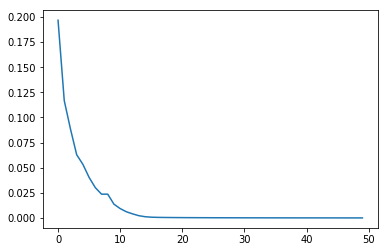

In [30]:
plt.plot(NN.loss)
plt.title("NN")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [31]:
print(accuracy_score(y_val,y_pred))

0.97925


In [8]:
y_train_one_hot

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])